# Goal

To produce a file which contains all collaborative relationships between coauthors. I have ~75k publications from our 1041 CHW authors, where each publication contains a list of coauthors.

I need to get all pairwise relationships between the coauthors and a list of all unique CHW authors.

In [1]:
import numpy as np
import pandas as pd
import utils.misc as um
import itertools

In [4]:
df = pd.read_csv('../Datasets/pca_results_jan11.csv', index_col = 0)

# df = df_auths[df_auths['affil'] == 'ACHRI']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 1 to 2218
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Auid    2218 non-null   int64  
 1   affil   2218 non-null   object 
 2   PC1     2218 non-null   float64
 3   PC2     2218 non-null   float64
 4   PC3     2218 non-null   float64
 5   PC4     2218 non-null   float64
 6   PC5     2218 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 138.6+ KB


,Auid,affil,PC1,PC2,PC3,PC4,PC5
1,6603220065,WCHRI,0.827744,-0.922260,-0.263634,-0.081958,-0.026032
2,7007033627,WCHRI,-0.852442,-0.373733,0.143818,-0.105422,-0.169255
3,16688012700,WCHRI,-0.046341,0.239816,-1.078307,-0.102526,0.086098
4,12902675100,WCHRI,1.192538,-0.634968,-0.316810,-0.268240,-0.151056
5,55366878700,WCHRI,0.615621,-1.228589,-0.149127,0.051756,-0.003176


In [16]:
# standardize PC1 scores to unit interval
df['PC1_norm'] = (df['PC1'] - df['PC1'].min())/(df['PC1'].max() - df['PC1'].min())

# rename Auid for Gephi
df.rename(columns={'Auid': 'Id'}, inplace=True)

# get nodes
nodes = df[['Id', 'affil', 'PC1', 'PC1_norm']]
nodes.to_excel('../Datasets/graph_nodes_jan12.xlsx', index = False)

# Examining the top PC1 researchers

Who are the researchers with highest PC1 scores?

In [70]:
q = .9
qtile = df['PC1_norm'].quantile(q=q)

top_q = df[df['PC1_norm'] >= qtile]
top_q

,Id,affil,PC1,PC2,PC3,PC4,PC5,PC1_norm
8,36097553800,WCHRI,1.884429,0.019890,0.298237,-0.140216,0.096072,0.424451
11,57221558934,WCHRI,1.755756,-0.730405,0.753451,-0.016661,0.013134,0.416495
26,7102398218,WCHRI,1.880938,0.191905,-0.140240,0.029564,-0.123008,0.424235
32,26433088400,WCHRI,1.971261,0.644799,0.587218,-0.080225,0.020051,0.429820
48,21645119700,WCHRI,1.584125,0.463698,0.252357,-0.034832,0.007761,0.405884
...,...,...,...,...,...,...,...,...
2201,57224718052,CHUSJ,1.677413,0.724861,-0.058407,-0.068462,0.021490,0.411652
2204,57224207210,Sickkids,1.788194,-0.666282,0.768048,-0.031532,0.010632,0.418501
2208,57224954701,BCCHR,1.575842,-0.473934,0.697132,0.022652,-0.007720,0.405372
2216,57283733600,McMaster,1.471465,-0.352540,0.944308,0.020505,-0.010261,0.398918


In [71]:
top_q.groupby('affil').count()

,Id,PC1,PC2,PC3,PC4,PC5,PC1_norm
affil,,,,,,,
ACHRI,29,29,29,29,29,29,29
BCCHR,29,29,29,29,29,29,29
CHRIM,15,15,15,15,15,15,15
CHUSJ,25,25,25,25,25,25,25
McMaster,21,21,21,21,21,21,21
Sickkids,70,70,70,70,70,70,70
WCHRI,33,33,33,33,33,33,33


In [78]:
df_auth = pd.read_excel("../Datasets/PCA_inputs_jan11.xlsx")
df_profiles = pd.read_excel("../Datasets/chw_author_profiles_jan11.xlsx")

df_auth = df_auth.merge(df_profiles, on='Auid')

In [80]:
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 0 to 2217
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Auid                       2218 non-null   int64  
 1   logistic_growth_rate_x     2218 non-null   float64
 2   mean_citations_per_year_x  2218 non-null   float64
 3   citation_count_x           2218 non-null   int64  
 4   cited_by_count_x           2218 non-null   int64  
 5   coauthor_count_x           2218 non-null   int64  
 6   document_count_x           2218 non-null   int64  
 7   h_index_x                  2218 non-null   int64  
 8   affil                      2218 non-null   object 
 9   publication_duration       2218 non-null   int64  
 10  author_count_median        2218 non-null   float64
 11  citedby_count_median       2218 non-null   float64
 12  openaccess_sum             2218 non-null   int64  
 13  author_position_median     2218 non-null   float

In [83]:
df_top = top_q.merge(df_auth, left_on='Id', right_on='Auid', how='inner')
df_top = df_top[['Auid', 'indexed_name', 'given_name', 'PC1_norm', 'affil_x', 'cited_by_count_x', 'publication_duration', 'logistic_growth_rate_x']]
df_top

,Auid,indexed_name,given_name,PC1_norm,affil_x,cited_by_count_x,publication_duration,logistic_growth_rate_x
0,36097553800,Al-Aklabi M.,Mohammed M.,0.424451,WCHRI,87,11,0.555441
1,57221558934,Altabtbaei K.,Khaled,0.416495,WCHRI,0,0,0.985034
2,7102398218,Berry F.,Fred B.,0.424235,WCHRI,719,25,0.607667
3,26433088400,Burton C.,Catherine E.,0.429820,WCHRI,58,12,0.624194
4,21645119700,Christian S.,Susan M.,0.405884,WCHRI,155,21,0.558183
...,...,...,...,...,...,...,...,...
217,57224718052,Lemay M.,Martin,0.411652,CHUSJ,10,6,1.250000
218,57224207210,Smith J.,Jennifer N.,0.418501,Sickkids,0,0,1.000000
219,57224954701,Lee J.,James,0.405372,BCCHR,0,0,0.985047
220,57283733600,Patterson S.,Sarah,0.398918,McMaster,0,0,1.000000


In [85]:
df_top[df_top['affil_x'] == 'WCHRI']

,Auid,indexed_name,given_name,PC1_norm,affil_x,cited_by_count_x,publication_duration,logistic_growth_rate_x
0,36097553800,Al-Aklabi M.,Mohammed M.,0.424451,WCHRI,87,11,0.555441
1,57221558934,Altabtbaei K.,Khaled,0.416495,WCHRI,0,0,0.985034
2,7102398218,Berry F.,Fred B.,0.424235,WCHRI,719,25,0.607667
3,26433088400,Burton C.,Catherine E.,0.429820,WCHRI,58,12,0.624194
4,21645119700,Christian S.,Susan M.,0.405884,WCHRI,155,21,0.558183
5,7103170769,Coe J.,James Yashu,0.393059,WCHRI,551,42,0.531258
6,13612247100,Corriveau-Bourque C.,Catherine,0.397115,WCHRI,24,5,1.250000
7,37000515500,Fletcher F.,Fay,0.395334,WCHRI,42,11,0.812265
8,55557546600,Foulds J.,Jessica L.,0.415030,WCHRI,15,9,1.250000
9,16642830800,Goez H.,Helly Rachel,0.416407,WCHRI,266,16,0.505040


# Build the graph edges

In [17]:
df_pubs = pd.read_csv('../Datasets/chw_publications.csv')
df_pubs.info()
print(df_pubs.columns[:25])
df_pubs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219997 entries, 0 to 219996
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CHW author           219997 non-null  int64  
 1   eid                  219997 non-null  object 
 2   doi                  205160 non-null  object 
 3   pii                  59958 non-null   object 
 4   pubmed_id            179365 non-null  float64
 5   title                219989 non-null  object 
 6   subtype              219997 non-null  object 
 7   subtypeDescription   219913 non-null  object 
 8   creator              219890 non-null  object 
 9   afid                 213954 non-null  object 
 10  affilname            213954 non-null  object 
 11  affiliation_city     213608 non-null  object 
 12  affiliation_country  213908 non-null  object 
 13  author_count         219929 non-null  float64
 14  author_names         219929 non-null  object 
 15  author_ids       

,CHW author,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,issueIdentifier,article_number,pageRange,description,authkeywords,citedby_count,openaccess,fund_acr,fund_no,fund_sponsor
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,4,NaN,309-317,Introduction: The World Health Organization cu...,biphasic | histology | molecular subtypes | Na...,1,0,MSFHR,undefined,Hannah's Heroes Foundation
1,6503856044,2-s2.0-85108228079,10.2217/pme-2020-0120,NaN,33973801.0,Deliberations about clinical pharmacogenetic t...,re,Review,Issa A.M.,60191838;60086967;60030835;60029502;60026553;6...,...,4,NaN,399-405,"This article summarizes the background, conten...",adverse reactions | deliberative consultation ...,0,0,CIHR,1-155872,Genome Canada
2,6503856044,2-s2.0-85104934944,10.1002/cam4.3910,NaN,33939292.0,Trametinib therapy for children with neurofibr...,ar,Article,Ronsley R.,60023077;60010365,...,11,NaN,3556-3564,Purpose: To describe a series of children with...,low-grade glioma | neurofibromatosis | pediatr...,1,1,NaN,undefined,NaN
3,6503856044,2-s2.0-85109755328,10.9778/cmajo.20200212,NaN,34021014.0,Family attitudes about and experiences with me...,ar,Article,Gibbard M.,60086967,...,2,NaN,E563-E569,BACKGROUND: Cannabis is legal for recreational...,NaN,2,1,NaN,undefined,NaN
4,6503856044,2-s2.0-85101694285,10.1016/S2352-4642(21)00020-1,S2352464221000201,33581749.0,Prevalence and risk factors for cisplatin-indu...,ar,Article,Moke D.J.,60086967;60030769;60029311;60023077;60020565;6...,...,4,NaN,274-283,Background: Cisplatin is used to treat a wide ...,NaN,5,0,NIH,P30CA014089,National Institutes of Health


In [18]:
# get only publications after 2015
df_pubs['Year'] = df_pubs['coverDate'].str.extract('^([0-9]*)-')

df_pubs['Year'] = df_pubs['Year'].apply(int)

df_pubs = df_pubs[df_pubs['Year'] >= 2015]
df_pubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91275 entries, 0 to 219996
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CHW author           91275 non-null  int64  
 1   eid                  91275 non-null  object 
 2   doi                  89853 non-null  object 
 3   pii                  23237 non-null  object 
 4   pubmed_id            74310 non-null  float64
 5   title                91274 non-null  object 
 6   subtype              91275 non-null  object 
 7   subtypeDescription   91193 non-null  object 
 8   creator              91205 non-null  object 
 9   afid                 89754 non-null  object 
 10  affilname            89754 non-null  object 
 11  affiliation_city     89693 non-null  object 
 12  affiliation_country  89743 non-null  object 
 13  author_count         91240 non-null  float64
 14  author_names         91240 non-null  object 
 15  author_ids           91240 non-null

In [19]:
def convert_to_int(x):
    """ Take x, possibly a list, and convert to int """
    try:
        if isinstance(x, list):
            return [int(i) for i in x]
        elif np.isnan(x):
            return 0
        else:
            return int(x)
        
    except:
        raise

In [20]:
df_pubs.loc[:, 'auids'] = df_pubs.loc[:, 'author_ids'].str.split(';')

# remove any missing rows
df_pubs = df_pubs[~df_pubs.author_ids.isna()]

# convert auids to int
df_pubs['auids'] = df_pubs['auids'].apply(um.convert_to_int)

In [21]:
# get the chw author positions - come back to see the ones not found in their own author lists
not_found = []

for i in df_pubs.index:
    try:
        df_pubs.loc[i, 'chw_author_position'] = df_pubs.loc[i, 'auids'].index(df_pubs.loc[i, 'CHW author'])
    except ValueError:
        not_found.append(i)
        
print('{} authors not found in their own author lists\n'.format(len(not_found)))

df_pubs.head()

783 authors not found in their own author lists



,CHW author,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,afid,...,description,authkeywords,citedby_count,openaccess,fund_acr,fund_no,fund_sponsor,Year,auids,chw_author_position
0,6503856044,2-s2.0-85102936784,10.1177/10935266211001986,NaN,33749384.0,Histologic Correlates of Molecular Group 4 Ped...,re,Review,Triscott J.,60193402;60023077;60020486;60018471;60010365;1...,...,Introduction: The World Health Organization cu...,biphasic | histology | molecular subtypes | Na...,1,0,MSFHR,undefined,Hannah's Heroes Foundation,2021,"[53882034800, 7102134322, 7403550284, 71018199...",4.0
1,6503856044,2-s2.0-85108228079,10.2217/pme-2020-0120,NaN,33973801.0,Deliberations about clinical pharmacogenetic t...,re,Review,Issa A.M.,60191838;60086967;60030835;60029502;60026553;6...,...,"This article summarizes the background, conten...",adverse reactions | deliberative consultation ...,0,0,CIHR,1-155872,Genome Canada,2021,"[7006615788, 57200159420, 6603414671, 36980983...",5.0
2,6503856044,2-s2.0-85104934944,10.1002/cam4.3910,NaN,33939292.0,Trametinib therapy for children with neurofibr...,ar,Article,Ronsley R.,60023077;60010365,...,Purpose: To describe a series of children with...,low-grade glioma | neurofibromatosis | pediatr...,1,1,NaN,undefined,NaN,2021,"[35272975600, 57204041913, 54388707200, 650385...",3.0
3,6503856044,2-s2.0-85109755328,10.9778/cmajo.20200212,NaN,34021014.0,Family attitudes about and experiences with me...,ar,Article,Gibbard M.,60086967,...,BACKGROUND: Cannabis is legal for recreational...,NaN,2,1,NaN,undefined,NaN,2021,"[57224506700, 57209177557, 6503856044, 6506014...",2.0
4,6503856044,2-s2.0-85101694285,10.1016/S2352-4642(21)00020-1,S2352464221000201,33581749.0,Prevalence and risk factors for cisplatin-indu...,ar,Article,Moke D.J.,60086967;60030769;60029311;60023077;60020565;6...,...,Background: Cisplatin is used to treat a wide ...,NaN,5,0,NIH,P30CA014089,National Institutes of Health,2021,"[57194505277, 57205079186, 24367129900, 162306...",4.0


In [22]:
# reduce the number of columns
df2 = df_pubs[['CHW author', 'eid', 'citedby_count', 'auids', 'chw_author_position', 'Year']]
df2

,CHW author,eid,citedby_count,auids,chw_author_position,Year
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021
1,6503856044,2-s2.0-85108228079,0,"[7006615788, 57200159420, 6603414671, 36980983...",5.0,2021
2,6503856044,2-s2.0-85104934944,1,"[35272975600, 57204041913, 54388707200, 650385...",3.0,2021
3,6503856044,2-s2.0-85109755328,2,"[57224506700, 57209177557, 6503856044, 6506014...",2.0,2021
4,6503856044,2-s2.0-85101694285,5,"[57194505277, 57205079186, 24367129900, 162306...",4.0,2021
...,...,...,...,...,...,...
219992,57220999344,2-s2.0-85097982774,1,"[55062176700, 56568449600, 56037870400, 572021...",4.0,2021
219993,57226726716,2-s2.0-85112413672,0,"[57225302207, 56196397400, 57226709101, 571893...",5.0,2021
219994,57241564300,2-s2.0-85100438652,0,"[35739201900, 57241564300]",1.0,2021
219995,57249145700,2-s2.0-85114437047,0,"[57220589090, 57218249433, 55192953600, 572491...",3.0,2021


In [23]:
# get the positions of each author in the list of auids
df2['coauthor_position'] = df2['auids'].apply(lambda x: list(enumerate(x)))
df2

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"[(0, 53882034800), (1, 7102134322), (2, 740355..."
1,6503856044,2-s2.0-85108228079,0,"[7006615788, 57200159420, 6603414671, 36980983...",5.0,2021,"[(0, 7006615788), (1, 57200159420), (2, 660341..."
2,6503856044,2-s2.0-85104934944,1,"[35272975600, 57204041913, 54388707200, 650385...",3.0,2021,"[(0, 35272975600), (1, 57204041913), (2, 54388..."
3,6503856044,2-s2.0-85109755328,2,"[57224506700, 57209177557, 6503856044, 6506014...",2.0,2021,"[(0, 57224506700), (1, 57209177557), (2, 65038..."
4,6503856044,2-s2.0-85101694285,5,"[57194505277, 57205079186, 24367129900, 162306...",4.0,2021,"[(0, 57194505277), (1, 57205079186), (2, 24367..."
...,...,...,...,...,...,...,...
219992,57220999344,2-s2.0-85097982774,1,"[55062176700, 56568449600, 56037870400, 572021...",4.0,2021,"[(0, 55062176700), (1, 56568449600), (2, 56037..."
219993,57226726716,2-s2.0-85112413672,0,"[57225302207, 56196397400, 57226709101, 571893...",5.0,2021,"[(0, 57225302207), (1, 56196397400), (2, 57226..."
219994,57241564300,2-s2.0-85100438652,0,"[35739201900, 57241564300]",1.0,2021,"[(0, 35739201900), (1, 57241564300)]"
219995,57249145700,2-s2.0-85114437047,0,"[57220589090, 57218249433, 55192953600, 572491...",3.0,2021,"[(0, 57220589090), (1, 57218249433), (2, 55192..."


In [24]:
# explode the 'coauthor_position' column
df2 = df2.explode('coauthor_position')
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)"
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)"


In [25]:
# get the coauthor positions and auids
df2['Target_position'] = df2['coauthor_position'].apply(lambda x: x[0])
df2['Target'] = df2['coauthor_position'].apply(lambda x: x[1])
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position,Target_position,Target
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)",0,53882034800
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)",1,7102134322
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)",2,7403550284
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)",3,7101819941
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)",4,6503856044


In [26]:
# find the distance between authors
df2['coauthor_distance'] = np.abs(df2['chw_author_position'] - df2['Target_position'])
df2.head()

,CHW author,eid,citedby_count,auids,chw_author_position,Year,coauthor_position,Target_position,Target,coauthor_distance
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(0, 53882034800)",0,53882034800,4.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(1, 7102134322)",1,7102134322,3.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(2, 7403550284)",2,7403550284,2.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(3, 7101819941)",3,7101819941,1.0
0,6503856044,2-s2.0-85102936784,1,"[53882034800, 7102134322, 7403550284, 71018199...",4.0,2021,"(4, 6503856044)",4,6503856044,0.0


In [27]:
# reset the index
df2.reset_index(drop=True, inplace=True)

# rename the 'CHW author' column
df2.rename(
    columns = {
        'CHW author': 'Source'
    },
    inplace = True
)

In [28]:
# drop the unused columns
edges = df2.drop(
    [
        'auids',
        'chw_author_position',
        'coauthor_position',
        'Target_position',
        'eid'
    ],
    axis = 1
)

In [29]:
edges

,Source,citedby_count,Year,Target,coauthor_distance
0,6503856044,1,2021,53882034800,4.0
1,6503856044,1,2021,7102134322,3.0
2,6503856044,1,2021,7403550284,2.0
3,6503856044,1,2021,7101819941,1.0
4,6503856044,1,2021,6503856044,0.0
...,...,...,...,...,...
1108154,57283733600,0,2021,57284830400,2.0
1108155,57283733600,0,2021,57193198855,3.0
1108156,57283733600,0,2021,7102290275,4.0
1108157,57283733600,0,2021,7401509446,5.0


In [30]:
# reorder the columns
edges = edges[['Source', 'Target', 'citedby_count', 'coauthor_distance', 'Year']]

# take out self-connections
edges = edges[edges['Source'] != edges['Target']]

# transform the skewed columns
# edges['log_citations'] = edges['citedby_count'].apply(lambda x: np.log(x + 1))
# edges['log_distance'] = edges['coauthor_distance'].apply(lambda x: np.log(x + 1))

# get edge weights - using a Gaussian for now
# sigma = 1
# edges['Weight'] = np.exp(-(edges['log_distance']**2/sigma))*edges['log_citations']
edges.head()

,Source,Target,citedby_count,coauthor_distance,Year
0,6503856044,53882034800,1,4.0,2021
1,6503856044,7102134322,1,3.0,2021
2,6503856044,7403550284,1,2.0,2021
3,6503856044,7101819941,1,1.0,2021
5,6503856044,6603195101,1,1.0,2021


In [30]:
# normalize weights to interval (0,1)
# edges['Weight'] = (edges['Weight'] - edges['Weight'].min())/(edges['Weight'].max() - edges['Weight'].min())

/home/matt/anaconda3/envs/main/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


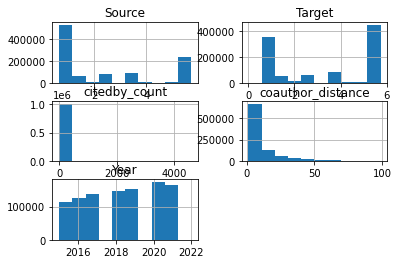

In [31]:
edges.hist();

In [32]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 1 to 2218
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        2218 non-null   int64  
 1   affil     2218 non-null   object 
 2   PC1       2218 non-null   float64
 3   PC1_norm  2218 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 86.6+ KB


In [33]:
df3 = pd.merge(edges, nodes, left_on = 'Source', right_on = 'Id').drop('Id', axis = 1)
df3

,Source,Target,citedby_count,coauthor_distance,Year,affil,PC1,PC1_norm
0,6503856044,53882034800,1,4.0,2021,BCCHR,-0.373709,0.284834
1,6503856044,7102134322,1,3.0,2021,BCCHR,-0.373709,0.284834
2,6503856044,7403550284,1,2.0,2021,BCCHR,-0.373709,0.284834
3,6503856044,7101819941,1,1.0,2021,BCCHR,-0.373709,0.284834
4,6503856044,6603195101,1,1.0,2021,BCCHR,-0.373709,0.284834
...,...,...,...,...,...,...,...,...
869915,57283733600,57284830400,0,2.0,2021,McMaster,1.471465,0.398918
869916,57283733600,57193198855,0,3.0,2021,McMaster,1.471465,0.398918
869917,57283733600,7102290275,0,4.0,2021,McMaster,1.471465,0.398918
869918,57283733600,7401509446,0,5.0,2021,McMaster,1.471465,0.398918


In [35]:
df3.rename(columns={'affil': 'Label'}, inplace=True)

# Custom edge weight function

After looking at various functions to weight the graph edges based on `citedby_count` and `coauthor_distance`, I've found a decent function that appears to be representative. Let $c$ be the number of citing documents for a collaboration and $d$ be the $L_1$ distance between coauthors. Then the edge weight is given by
$$
    w(c,d) = \frac{\log_{10}(c+1)}{\sqrt{d}} + 1.
$$

In [41]:
# apply the custom edge weights
df3['Weight'] = np.log10(df3['citedby_count'] + 1)/np.sqrt(df3['coauthor_distance']) + 1
df3.head()

,Source,Target,citedby_count,coauthor_distance,Year,Label,PC1,PC1_norm,Weight
0,6503856044,53882034800,1,4.0,2021,BCCHR,-0.373709,0.284834,1.150515
1,6503856044,7102134322,1,3.0,2021,BCCHR,-0.373709,0.284834,1.173800
2,6503856044,7403550284,1,2.0,2021,BCCHR,-0.373709,0.284834,1.212860
3,6503856044,7101819941,1,1.0,2021,BCCHR,-0.373709,0.284834,1.301030
4,6503856044,6603195101,1,1.0,2021,BCCHR,-0.373709,0.284834,1.301030


In [42]:
df3['Weight'].describe()

count    813213.000000
mean          1.441416
std           0.385912
min           1.000000
25%           1.169375
50%           1.353553
75%           1.615224
max           4.662852
Name: Weight, dtype: float64

In [43]:
df3.to_csv('../Datasets/graph_edges_jan12.csv', index = False)